# start

In [1]:
day = 7

In [2]:
# import pandas as pd
import numpy as np

import os

import regex as re

from anytree import Node, RenderTree

In [3]:
INPUT_DIR = "../input"

input_path = f'{INPUT_DIR}/day{day:02d}.txt'

data = []
with open(input_path) as file:
#     data = file.readlines()
    for line in file.readlines():
        data.append(line.strip('\n'))

In [4]:
data[:15]

['$ cd /',
 '$ ls',
 'dir plws',
 'dir pwlbgbz',
 'dir pwtpltr',
 'dir szn',
 '$ cd plws',
 '$ ls',
 'dir ffpzc',
 'dir frcmjzts',
 '92461 nbvnzg',
 'dir phqcg',
 '21621 vqgsglwq',
 '$ cd ffpzc',
 '$ ls']

In [5]:
len(data)

979

# dev code

## dev logic

CLI output:
```
    $ cd /
    $ ls
    dir a
    14848514 b.txt
    8504156 c.dat
    dir d
    $ cd a
    $ ls
    dir e
    29116 f
    2557 g
    62596 h.lst
    $ cd e
    $ ls
    584 i
    $ cd ..
    $ cd ..
    $ cd d
    $ ls
    4060174 j
    8033020 d.log
    5626152 d.ext
    7214296 k
```

- / (dir)
  - a (dir)
    - e (dir)
      - i (file, size=584)
    - f (file, size=29116)
    - g (file, size=2557)
    - h.lst (file, size=62596)
  - b.txt (file, size=14848514)
  - c.dat (file, size=8504156)
  - d (dir)
    - j (file, size=4060174)
    - d.log (file, size=8033020)
    - d.ext (file, size=5626152)
    - k (file, size=7214296)

In [ ]:
import networkx as nx

In [72]:
g = nx.DiGraph()
# g = nx.Graph()

g.add_edge('/', 'a')
g.add_edge('a', 'b.txt', size=14848514)
g.add_edge('a', 'c.dat', size=8504156)
g.add_edge('a', 'e')
g.add_edge('e', 'i', size=584)

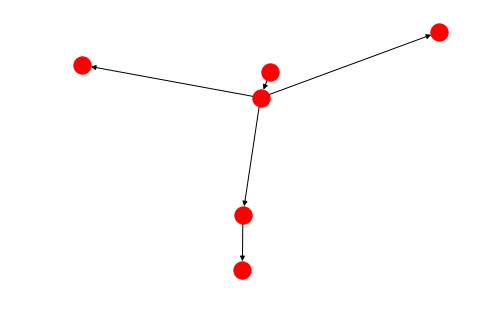

In [73]:
nx.draw(g)

In [74]:
g['a']

AtlasView({'b.txt': {'size': 14848514}, 'c.dat': {'size': 8504156}, 'e': {}})

In [75]:
g['e']

AtlasView({'i': {'size': 584}})

In [76]:
g.has_edge('e', 'a')

False

In [77]:
g.has_edge('a', 'e')

True

In [78]:
def get_nodes_size(node, graph):
    tot = 0
    for subnode, info in graph[node].items():
        if 'size' in info.keys():
            tot += info['size']
        else:
            tot += get_nodes_size(subnode, graph)
    
    return tot

In [79]:
get_nodes_size('e', g)

584

In [80]:
get_nodes_size('a', g)

23353254

In [81]:
14848514 + 8504156 + 584

23353254

### tree

In [7]:
from anytree import Node, RenderTree

In [10]:
tree = Node("/")
a = Node("a", parent=tree)
b_txt = Node("b.txt", parent=a, size=14848514)

In [11]:
for pre, fill, node in RenderTree(tree):
    print("%s%s" % (pre, node.name))

/
└── a
    └── b.txt


In [12]:
c_dat = Node("c.dat", parent=a, size=8504156)
e = Node("e", parent=a)
i_file = Node("i", parent=e, size=584)

In [13]:
for pre, fill, node in RenderTree(tree):
    print("%s%s" % (pre, node.name))

/
└── a
    ├── b.txt
    ├── c.dat
    └── e
        └── i


In [16]:
hasattr(a, "size")

False

In [15]:
hasattr(b_txt, "size")

True

In [19]:
for pre, fill, node in RenderTree(tree):
    if hasattr(node, "size"):
        print("%s%s (%s)" % (pre, node.name, node.size))
    else:
        print("%s%s" % (pre, node.name))

/
└── a
    ├── b.txt (14848514)
    ├── c.dat (8504156)
    └── e
        └── i (584)


In [32]:
def render_tree_with_size(root_node):
    for pre, fill, node in RenderTree(root_node):
        if hasattr(node, "size"):
            print("%s%s (%s)" % (pre, node.name, node.size))
        else:
            print("%s%s" % (pre, node.name))

In [24]:

tot = 0
for pre, fill, node in RenderTree(e):
    if hasattr(node, "size"):
        tot += node.size
#     else:
#         tot += get_size_tree(node)

In [25]:
tot

584

In [28]:

tot = 0
for pre, fill, node in RenderTree(a):
    if hasattr(node, "size"):
        tot += node.size
        print(node.name, node.size)
    else:
        print(node.name)
        
#         tot += get_size_tree(node)

tot

a
b.txt 14848514
c.dat 8504156
e
i 584


23353254

In [8]:
def get_size_tree(node_obj):
    tot = 0
    for pre, fill, node in RenderTree(node_obj):
        if hasattr(node, "size"):
            tot += node.size
    
    return tot

In [30]:
get_size_tree(e)

584

In [31]:
get_size_tree(a)

23353254

In [32]:
tree.children

(Node('///a'),)

In [33]:
a.children

(Node('///a/b.txt', size=14848514),
 Node('///a/c.dat', size=8504156),
 Node('///a/e'))

In [34]:
a.parent

Node('//')

## dev parsing

In [12]:
test_commands = """$ cd /
$ ls
dir a
14848514 b.txt
8504156 c.dat
dir d
$ cd a
$ ls
dir e
29116 f
2557 g
62596 h.lst
$ cd e
$ ls
584 i
$ cd ..
$ cd ..
$ cd d
$ ls
4060174 j
8033020 d.log
5626152 d.ext
7214296 k"""

In [46]:
for i, line in enumerate(test_commands.split('\n')):
    if line.startswith("$"):
        print(line)

$ cd /
$ ls
$ cd a
$ ls
$ cd e
$ ls
$ cd ..
$ cd ..
$ cd d
$ ls


In [6]:
import regex as re

In [55]:
# parent_dir = ''
current_dir = ''
tree_dict = {}
list_mode = False

for i, line in enumerate(test_commands.split('\n')):
    print(line, "--", current_dir, list_mode)
    
    if line.startswith("$"): # command
        list_mode = False # turn off list mode
        line_mod = line.lstrip("$ ")
        
        if line_mod[:3] == "cd ": # change directory
            cwd = line_mod[3:]
            if cwd == "/": # rename "/" so it's easier to work with
                cwd = "root"
            current_dir = cwd
            if cwd not in tree_dict.keys():
                print("adding Node:", cwd)
                tree_dict[cwd] = Node(cwd)

        elif line_mod[:3] == "ls": # list directory
            list_mode = True
            list_dir = line_mod[3:]
            if list_dir == "":
                list_dir = current_dir
            continue
    
    if list_mode:
        info, file_name = line.split(' ')
        if re.match("\d+", info):
            file_size = int(info)
            print("adding Node:", file_name)
            tree_dict[file_name] = Node(file_name, parent=tree_dict[current_dir], size=file_size)
        elif info == "dir":
            print("adding Node:", file_name)
            tree_dict[file_name] = Node(file_name, parent=tree_dict[current_dir])

$ cd / --  False
adding Node: root
$ ls -- root False
dir a -- root True
adding Node: a
14848514 b.txt -- root True
adding Node: b.txt
8504156 c.dat -- root True
adding Node: c.dat
dir d -- root True
adding Node: d
$ cd a -- root True
$ ls -- a False
dir e -- a True
adding Node: e
29116 f -- a True
adding Node: f
2557 g -- a True
adding Node: g
62596 h.lst -- a True
adding Node: h.lst
$ cd e -- a True
$ ls -- e False
584 i -- e True
adding Node: i
$ cd .. -- e True
adding Node: ..
$ cd .. -- .. False
$ cd d -- .. False
$ ls -- d False
4060174 j -- d True
adding Node: j
8033020 d.log -- d True
adding Node: d.log
5626152 d.ext -- d True
adding Node: d.ext
7214296 k -- d True
adding Node: k


In [52]:
tree_dict

{'root': Node('/root'),
 'a': Node('/root/a'),
 'b.txt': Node('/root/b.txt', size=14848514),
 'c.dat': Node('/root/c.dat', size=8504156),
 'd': Node('/root/d'),
 'e': Node('/root/a/e'),
 'f': Node('/root/a/f', size=29116),
 'g': Node('/root/a/g', size=2557),
 'h.lst': Node('/root/a/h.lst', size=62596),
 'i': Node('/root/a/e/i', size=584),
 '..': Node('/..'),
 'j': Node('/root/d/j', size=4060174),
 'd.log': Node('/root/d/d.log', size=8033020),
 'd.ext': Node('/root/d/d.ext', size=5626152),
 'k': Node('/root/d/k', size=7214296)}

In [53]:
for pre, fill, node in RenderTree(tree_dict['root']):
    print("%s%s" % (pre, node.name))

root
├── a
│   ├── e
│   │   └── i
│   ├── f
│   ├── g
│   └── h.lst
├── b.txt
├── c.dat
└── d
    ├── j
    ├── d.log
    ├── d.ext
    └── k


In [57]:
pd = tree_dict['e'].parent
pd

Node('/root/a')

In [59]:
pd.name

'a'

In [60]:
tree_dict[pd.name]

Node('/root/a')

In [61]:
tree_dict[pd.name].children

(Node('/root/a/e'),
 Node('/root/a/f', size=29116),
 Node('/root/a/g', size=2557),
 Node('/root/a/h.lst', size=62596))

In [41]:
tree_dict['a']

Node('/a')

In [62]:
get_size_tree(tree_dict['a'])

94853

In [63]:
get_size_tree(tree_dict['d'])

24933642

In [64]:
get_size_tree(tree_dict['root'])

48381165

In [66]:
current_dir = ''
tree_dict = {}
list_mode = False

for i, line in enumerate(test_commands.split('\n')):
    print(line, "--", current_dir, list_mode)
    
    if line.startswith("$"): # command
        list_mode = False # turn off list mode
        line_mod = line.lstrip("$ ")
        
        if line_mod[:3] == "cd ": # change directory
            cwd = line_mod[3:]
            if cwd == "..":
                parent_dir = tree_dict[current_dir].parent
                current_dir = tree_dict[parent_dir.name].name
                continue
            else:
                if cwd == "/": # rename "/" so it's easier to work with
                    cwd = "root"
                current_dir = cwd
                if cwd not in tree_dict.keys():
                    print("adding Node:", cwd)
                    tree_dict[cwd] = Node(cwd)
                continue
        
        elif line_mod[:3] == "ls": # list directory
            list_mode = True
            list_dir = line_mod[3:]
            if list_dir == "":
                list_dir = current_dir
            continue
    
    if list_mode:
        info, file_name = line.split(' ')
        if re.match("\d+", info):
            file_size = int(info)
            print("adding Node:", file_name)
            tree_dict[file_name] = Node(file_name, parent=tree_dict[current_dir], size=file_size)
        elif info == "dir":
            print("adding Node:", file_name)
            tree_dict[file_name] = Node(file_name, parent=tree_dict[current_dir])

$ cd / --  False
adding Node: root
$ ls -- root False
dir a -- root True
adding Node: a
14848514 b.txt -- root True
adding Node: b.txt
8504156 c.dat -- root True
adding Node: c.dat
dir d -- root True
adding Node: d
$ cd a -- root True
$ ls -- a False
dir e -- a True
adding Node: e
29116 f -- a True
adding Node: f
2557 g -- a True
adding Node: g
62596 h.lst -- a True
adding Node: h.lst
$ cd e -- a True
$ ls -- e False
584 i -- e True
adding Node: i
$ cd .. -- e True
$ cd .. -- a False
$ cd d -- root False
$ ls -- d False
4060174 j -- d True
adding Node: j
8033020 d.log -- d True
adding Node: d.log
5626152 d.ext -- d True
adding Node: d.ext
7214296 k -- d True
adding Node: k


## add in Node type

In [75]:
tree = Node("/", type="dir")

a = Node("a", parent=tree, type="dir")
b_txt = Node("b.txt", parent=a, type="file", size=14848514)

c_dat = Node("c.dat", parent=a, type='file', size=8504156)
e = Node("e", parent=a, type='dir')
i_file = Node("i", parent=e, type='file', size=584)

In [76]:
render_tree_with_size(tree)

/
└── a
    ├── b.txt (14848514)
    ├── c.dat (8504156)
    └── e
        └── i (584)


In [9]:
def render_tree_with_size(root_node):
    for pre, fill, node in RenderTree(root_node):
        if node.type == "file":
#         if hasattr(node, "size"):
            print("%s%s (%s)" % (pre, node.name, node.size))
        elif node.type == "dir":
            print("%s%s" % (pre, node.name))
        else:
            print("Unknown node type: ", node)

In [78]:
render_tree_with_size(tree)

/
└── a
    ├── b.txt (14848514)
    ├── c.dat (8504156)
    └── e
        └── i (584)


In [10]:
def sum_all_dirs(root_node):
    node_size_dict = {}
    for pre, fill, node in RenderTree(root_node):
        if node.type == "dir":
            node_size_dict[node.name] = get_size_tree(node)
    return node_size_dict

In [ ]:
sum_all_dirs(tree)

# run part 1

## funcs

In [6]:
def render_tree_with_size(root_node):
    for pre, fill, node in RenderTree(root_node):
        if node.type == "file":
            print("%s%s (%s)" % (pre, node.name, node.size))
        elif node.type == "dir":
            print("%s%s" % (pre, node.name))
        else:
            print("Unknown node type: ", node)

In [7]:
def get_size_tree(node_obj):
    tot = 0
    for pre, fill, node in RenderTree(node_obj):
        if hasattr(node, "size"):
            tot += node.size
    
    return tot

In [8]:
def sum_all_dirs(root_node):
    node_size_dict = {}
    for pre, fill, node in RenderTree(root_node):
        if node.type == "dir":
            node_size_dict[node.name] = get_size_tree(node)
    return node_size_dict

In [51]:
def parse_commands(command_list):
    current_dir = ''
    tree_dict = {}
    list_mode = False

    for i, line in enumerate(command_list):
        print(f"{line}, (cwd: {current_dir}, list_mode: {list_mode})")

        if line.startswith("$"): # command
            list_mode = False # turn off list mode
            line_mod = line.lstrip("$ ")

            if line_mod[:3] == "cd ": # change directory
                cwd = line_mod[3:]
                if cwd == "..":
                    parent_dir = tree_dict[current_dir].parent
                    current_dir = tree_dict[parent_dir.name].name
                    continue
                else:
                    if cwd == "/": # rename "/" so it's easier to work with
                        cwd = "root"
                    current_dir = cwd
                    if cwd not in tree_dict.keys():
#                         print("adding Node:", cwd)
                        tree_dict[cwd] = Node(cwd, type="dir")
                    continue

            elif line_mod[:2] == "ls": # list directory
                list_mode = True
                list_dir = line_mod[3:]
                if list_dir == "":
                    list_dir = current_dir
                continue

        if list_mode:
            info, file_name = line.split(' ')
            if re.match("\d+", info):
                file_size = int(info)
#                 print("adding Node:", file_name)
                tree_dict[file_name] = Node(file_name, 
                                            parent=tree_dict[current_dir], 
                                            type="file",
                                            size=file_size)
            elif info == "dir":
#                 print("adding Node:", file_name)
                tree_dict[file_name] = Node(file_name, 
                                            parent=tree_dict[current_dir],
                                            type="dir")
        
    
    return tree_dict

In [63]:
def do_the_rest(tree_dict, root_dir_name='root'):
    dir_sizes = sum_all_dirs(tree_dict[root_dir_name])
    filt_dir_size_list = [v for k,v in dir_sizes.items() if v <= 100000]
    return np.sum(filt_dir_size_list)

## test

In [53]:
test_commands = """$ cd /
$ ls
dir a
14848514 b.txt
8504156 c.dat
dir d
$ cd a
$ ls
dir e
29116 f
2557 g
62596 h.lst
$ cd e
$ ls
584 i
$ cd ..
$ cd ..
$ cd d
$ ls
4060174 j
8033020 d.log
5626152 d.ext
7214296 k"""

In [54]:
test_commands = test_commands.split("\n")

In [55]:
test_tree = parse_commands(test_commands)

$ cd /, (cwd: , list_mode: False)
$ ls, (cwd: root, list_mode: False)
dir a, (cwd: root, list_mode: True)
14848514 b.txt, (cwd: root, list_mode: True)
8504156 c.dat, (cwd: root, list_mode: True)
dir d, (cwd: root, list_mode: True)
$ cd a, (cwd: root, list_mode: True)
$ ls, (cwd: a, list_mode: False)
dir e, (cwd: a, list_mode: True)
29116 f, (cwd: a, list_mode: True)
2557 g, (cwd: a, list_mode: True)
62596 h.lst, (cwd: a, list_mode: True)
$ cd e, (cwd: a, list_mode: True)
$ ls, (cwd: e, list_mode: False)
584 i, (cwd: e, list_mode: True)
$ cd .., (cwd: e, list_mode: True)
$ cd .., (cwd: a, list_mode: False)
$ cd d, (cwd: root, list_mode: False)
$ ls, (cwd: d, list_mode: False)
4060174 j, (cwd: d, list_mode: True)
8033020 d.log, (cwd: d, list_mode: True)
5626152 d.ext, (cwd: d, list_mode: True)
7214296 k, (cwd: d, list_mode: True)


In [46]:
do_the_rest(test_tree)

95437

In [13]:
test_tree

{'root': Node('/root', type='dir'),
 'a': Node('/root/a', type='dir'),
 'b.txt': Node('/root/b.txt', size=14848514, type='file'),
 'c.dat': Node('/root/c.dat', size=8504156, type='file'),
 'd': Node('/root/d', type='dir'),
 'e': Node('/root/a/e', type='dir'),
 'f': Node('/root/a/f', size=29116, type='file'),
 'g': Node('/root/a/g', size=2557, type='file'),
 'h.lst': Node('/root/a/h.lst', size=62596, type='file'),
 'i': Node('/root/a/e/i', size=584, type='file'),
 'j': Node('/root/d/j', size=4060174, type='file'),
 'd.log': Node('/root/d/d.log', size=8033020, type='file'),
 'd.ext': Node('/root/d/d.ext', size=5626152, type='file'),
 'k': Node('/root/d/k', size=7214296, type='file')}

In [14]:
render_tree_with_size(test_tree['root'])

root
├── a
│   ├── e
│   │   └── i (584)
│   ├── f (29116)
│   ├── g (2557)
│   └── h.lst (62596)
├── b.txt (14848514)
├── c.dat (8504156)
└── d
    ├── j (4060174)
    ├── d.log (8033020)
    ├── d.ext (5626152)
    └── k (7214296)


In [15]:
test_dir_sizes = sum_all_dirs(test_tree['root'])

In [16]:
test_dir_sizes

{'root': 48381165, 'a': 94853, 'e': 584, 'd': 24933642}

In [17]:
test_dir_size_list = [v for k,v in test_dir_sizes.items() if v <= 100000]

In [18]:
test_dir_size_list

[94853, 584]

In [19]:
np.sum(test_dir_size_list)

95437

## for real

In [47]:
part1_tree = parse_commands(data)

$ cd /, (cwd: , list_mode: False)
$ ls, (cwd: root, list_mode: False)
dir plws, (cwd: root, list_mode: True)
dir pwlbgbz, (cwd: root, list_mode: True)
dir pwtpltr, (cwd: root, list_mode: True)
dir szn, (cwd: root, list_mode: True)
$ cd plws, (cwd: root, list_mode: True)
$ ls, (cwd: plws, list_mode: False)
dir ffpzc, (cwd: plws, list_mode: True)
dir frcmjzts, (cwd: plws, list_mode: True)
92461 nbvnzg, (cwd: plws, list_mode: True)
dir phqcg, (cwd: plws, list_mode: True)
21621 vqgsglwq, (cwd: plws, list_mode: True)
$ cd ffpzc, (cwd: plws, list_mode: True)
$ ls, (cwd: ffpzc, list_mode: False)
48459 dzdfc.vqq, (cwd: ffpzc, list_mode: True)
143107 jql.jzl, (cwd: ffpzc, list_mode: True)
208330 mmnvqn.hqb, (cwd: ffpzc, list_mode: True)
290122 svjvhflz, (cwd: ffpzc, list_mode: True)
218008 wjlmgq, (cwd: ffpzc, list_mode: True)
$ cd .., (cwd: ffpzc, list_mode: True)
$ cd frcmjzts, (cwd: plws, list_mode: False)
$ ls, (cwd: frcmjzts, list_mode: False)
dir bsltmjz, (cwd: frcmjzts, list_mode: True)


In [48]:
do_the_rest(part1_tree)

946997

In [21]:
part1_dir_sizes = sum_all_dirs(part1_tree['root'])

now, sum the total sizes of those directories

In [22]:
part1_dir_size_list = [v for k,v in part1_dir_sizes.items() if v <= 100000]

In [23]:
len(part1_dir_sizes), len(part1_dir_size_list)

(131, 22)

In [24]:
np.sum(part1_dir_size_list)

946997

In [31]:
part1_dir_size_list

[14981,
 955,
 22963,
 0,
 60566,
 80072,
 82485,
 32343,
 55058,
 18509,
 8326,
 283,
 63263,
 88980,
 88980,
 93470,
 1238,
 44239,
 3286,
 40920,
 47522,
 98558]

In [34]:
render_tree_with_size(part1_tree['root'])

root
├── plws
│   ├── ffpzc
│   │   ├── dzdfc.vqq (48459)
│   │   ├── jql.jzl (143107)
│   │   ├── mmnvqn.hqb (208330)
│   │   ├── svjvhflz (290122)
│   │   └── wjlmgq (218008)
│   ├── frcmjzts
│   │   ├── bsltmjz
│   │   │   ├── dzdfc.vqq (34237)
│   │   │   └── mdgdhqgw (58741)
│   │   └── jfzgrbm
│   │       ├── fcmpng (132811)
│   │       ├── lgt.swt (103661)
│   │       ├── vqgsglwq (173031)
│   │       └── wprjfg.zbr (29134)
│   ├── nbvnzg (92461)
│   ├── phqcg
│   │   └── jgfs.zjw (955)
│   └── vqgsglwq (21621)
├── pwlbgbz
│   ├── gbg
│   │   ├── fcsjl.bzm (287003)
│   │   └── wgq
│   │       └── fcsjl.fcm (22963)
│   ├── mjzhcwrd
│   │   ├── clfnpmbq.zmb (228632)
│   │   ├── dzdfc.vqq (28276)
│   │   └── tdbg.wgn (2982)
│   ├── njcscpj
│   │   ├── dqzgqgv
│   │   │   ├── dzdfc.vqq (70309)
│   │   │   ├── fcsjl (56139)
│   │   │   ├── sgwz.cdz (142095)
│   │   │   ├── snjntth
│   │   │   │   ├── ffpzc (51918)
│   │   │   │   └── vrfgfds
│   │   │   │       └── jlscz (155233)
│  

## wrong

In [70]:
data[:25]

['$ cd /',
 '$ ls',
 'dir plws',
 'dir pwlbgbz',
 'dir pwtpltr',
 'dir szn',
 '$ cd plws',
 '$ ls',
 'dir ffpzc',
 'dir frcmjzts',
 '92461 nbvnzg',
 'dir phqcg',
 '21621 vqgsglwq',
 '$ cd ffpzc',
 '$ ls',
 '48459 dzdfc.vqq',
 '143107 jql.jzl',
 '208330 mmnvqn.hqb',
 '290122 svjvhflz',
 '218008 wjlmgq',
 '$ cd ..',
 '$ cd frcmjzts',
 '$ ls',
 'dir bsltmjz',
 'dir jfzgrbm']

In [39]:
len(part1_dir_sizes)

131

In [41]:
len([x for x in data if x.startswith("$ cd ")])

348

In [42]:
len([x for x in data if x == "$ cd .."])

172

In [43]:
348 - 172

176

In [44]:
len([x for x in data if x.startswith("$ ls")])

176

In [45]:
len([x for x in data if x == "$ ls"])

176

In [83]:
len([x for x in data if x == "$ cd /"])

1

I think we want there to be this many directories, but we only have 131

In [26]:
data[0]

'$ cd /'

In [25]:
data[0][:5]

'$ cd '

In [87]:
def parse_commands(command_list):
    current_dir = ''
    tree_dict = {}
    list_mode = False

    for i, line in enumerate(command_list):
#         print(f"{line}, (cwd: {current_dir}, list_mode: {list_mode})")

        if line.startswith("$"): # command
            list_mode = False # turn off list mode
            line_mod = line.lstrip("$ ")

            if line_mod[:3] == "cd ": # change directory
                change_to = line_mod[3:]
                if change_to == "..":
                    parent_dir = tree_dict[current_dir].parent
                    current_dir = tree_dict[parent_dir.name].name
                    continue
                else:
                    current_dir = change_to
                    # this is only ever executed on the first line (the root dir)
                    if change_to not in tree_dict.keys():
                        tree_dict[change_to] = Node(change_to, 
                                                    type="dir")
                    continue

            elif line_mod[:2] == "ls": # list directory
                list_mode = True
                continue

        if list_mode:
            info, file_name = line.split(' ')
            if re.match("\d+", info):
                file_size = int(info)
#                 print("adding Node:", file_name)
                tree_dict[file_name] = Node(file_name, 
                                            parent=tree_dict[current_dir], 
                                            type="file",
                                            size=file_size)
            elif info == "dir":
#                 print("adding Node:", file_name)
                tree_dict[file_name] = Node(file_name, 
                                            parent=tree_dict[current_dir],
                                            type="dir")
            else:
                print("Unidentified line 'info' type: ", i, line)
    
#     print(missing_parent)
    return tree_dict

In [88]:
part1_take2_tree = parse_commands(data)

In [89]:
do_the_rest(part1_take2_tree, '/')

946997

In [74]:
len(part1_take2_tree)

315

In [86]:
part1_take2_tree

{'/': Node('//', type='dir'),
 'plws': Node('///plws', type='dir'),
 'pwlbgbz': Node('///pwlbgbz', type='dir'),
 'pwtpltr': Node('///pwtpltr', type='dir'),
 'szn': Node('///szn', type='dir'),
 'ffpzc': Node('///szn/snjntth/zshh/ffpzc', type='dir'),
 'frcmjzts': Node('///plws/frcmjzts', type='dir'),
 'nbvnzg': Node('///plws/nbvnzg', size=92461, type='file'),
 'phqcg': Node('///plws/phqcg', type='dir'),
 'vqgsglwq': Node('///szn/zjbp/nmtjtd/vqgsglwq', size=51081, type='file'),
 'dzdfc.vqq': Node('///szn/snjntth/zshh/ffpzc/snjntth/dzdfc.vqq', size=86775, type='file'),
 'jql.jzl': Node('///plws/ffpzc/jql.jzl', size=143107, type='file'),
 'mmnvqn.hqb': Node('///szn/snjntth/lfb/mmnvqn.hqb', size=9704, type='file'),
 'svjvhflz': Node('///plws/ffpzc/svjvhflz', size=290122, type='file'),
 'wjlmgq': Node('///szn/snjntth/lfb/zwhvmln/wzcq/snjntth/wjlmgq', size=117276, type='file'),
 'bsltmjz': Node('///pwtpltr/jst/jsqjcqnt/bsltmjz', type='dir'),
 'jfzgrbm': Node('///plws/frcmjzts/jfzgrbm', type='d

In [77]:
part1_take2_tree['plws'].parent

Node('//', type='dir')

In [78]:
part1_take2_tree['plws'].parent.name

'/'

In [76]:
data[:20]

['$ cd /',
 '$ ls',
 'dir plws',
 'dir pwlbgbz',
 'dir pwtpltr',
 'dir szn',
 '$ cd plws',
 '$ ls',
 'dir ffpzc',
 'dir frcmjzts',
 '92461 nbvnzg',
 'dir phqcg',
 '21621 vqgsglwq',
 '$ cd ffpzc',
 '$ ls',
 '48459 dzdfc.vqq',
 '143107 jql.jzl',
 '208330 mmnvqn.hqb',
 '290122 svjvhflz',
 '218008 wjlmgq']

In [90]:
for x in data[:25]:
    print(x)

$ cd /
$ ls
dir plws
dir pwlbgbz
dir pwtpltr
dir szn
$ cd plws
$ ls
dir ffpzc
dir frcmjzts
92461 nbvnzg
dir phqcg
21621 vqgsglwq
$ cd ffpzc
$ ls
48459 dzdfc.vqq
143107 jql.jzl
208330 mmnvqn.hqb
290122 svjvhflz
218008 wjlmgq
$ cd ..
$ cd frcmjzts
$ ls
dir bsltmjz
dir jfzgrbm


In [95]:
files_in_input = [x for x in data if re.match("\d+", x)]
# len([x for x in data if re.match("\d+", x)])
len(files_in_input)

280

In [96]:
files_in_input[:5]

['92461 nbvnzg',
 '21621 vqgsglwq',
 '48459 dzdfc.vqq',
 '143107 jql.jzl',
 '208330 mmnvqn.hqb']

In [98]:
files_in_output = [k for k,v in part1_take2_tree.items() if v.type == "file"]
# len([k for k,v in part1_take2_tree.items() if v.type == "file"])
len(files_in_output)

184

In [100]:
files_in_output[:10]

['nbvnzg',
 'vqgsglwq',
 'dzdfc.vqq',
 'jql.jzl',
 'mmnvqn.hqb',
 'svjvhflz',
 'wjlmgq',
 'mdgdhqgw',
 'fcmpng',
 'lgt.swt']

In [101]:
mod_files_input = [x.split(' ')[1] for x in files_in_input]

In [102]:
mod_files_input[:10]

['nbvnzg',
 'vqgsglwq',
 'dzdfc.vqq',
 'jql.jzl',
 'mmnvqn.hqb',
 'svjvhflz',
 'wjlmgq',
 'dzdfc.vqq',
 'mdgdhqgw',
 'fcmpng']

In [105]:
missing_files = set(mod_files_input).difference(set(files_in_output))

In [106]:
len(missing_files)

5

In [107]:
missing_files

{'bsltmjz', 'fcsjl', 'ffpzc', 'snjntth', 'sphbzn'}

In [114]:
diff = [x for x in mod_files_input if x not in files_in_output]

In [115]:
len(diff)

14

In [116]:
diff

['ffpzc',
 'fcsjl',
 'ffpzc',
 'snjntth',
 'snjntth',
 'bsltmjz',
 'ffpzc',
 'sphbzn',
 'bsltmjz',
 'fcsjl',
 'bsltmjz',
 'snjntth',
 'fcsjl',
 'fcsjl']

In [121]:
len(mod_files_input), len(set(mod_files_input))

(280, 189)

In [108]:
from collections import Counter

In [122]:
c_in = Counter(mod_files_input)

In [126]:
c_in.most_common()[:5]

[('dzdfc.vqq', 22),
 ('vqgsglwq', 19),
 ('sgwz.cdz', 18),
 ('wjlmgq', 16),
 ('mmnvqn.hqb', 12)]

In [127]:
c_out = Counter(files_in_output)

In [118]:
len(c_out)

184

In [128]:
c_out.most_common()[:5]

[('nbvnzg', 1),
 ('vqgsglwq', 1),
 ('dzdfc.vqq', 1),
 ('jql.jzl', 1),
 ('mmnvqn.hqb', 1)]

In [130]:
[(i, x) for i, x in enumerate(data) if 'dzdfc.vqq' in x]

[(15, '48459 dzdfc.vqq'),
 (27, '34237 dzdfc.vqq'),
 (64, '28276 dzdfc.vqq'),
 (74, '70309 dzdfc.vqq'),
 (127, '46843 dzdfc.vqq'),
 (168, '172168 dzdfc.vqq'),
 (183, '58942 dzdfc.vqq'),
 (405, '202530 dzdfc.vqq'),
 (417, '187837 dzdfc.vqq'),
 (454, '29735 dzdfc.vqq'),
 (477, '226757 dzdfc.vqq'),
 (538, '222389 dzdfc.vqq'),
 (578, '300362 dzdfc.vqq'),
 (582, '252983 dzdfc.vqq'),
 (589, '141984 dzdfc.vqq'),
 (644, '212740 dzdfc.vqq'),
 (710, '88980 dzdfc.vqq'),
 (728, '223564 dzdfc.vqq'),
 (750, '107058 dzdfc.vqq'),
 (854, '137224 dzdfc.vqq'),
 (881, '147899 dzdfc.vqq'),
 (960, '86775 dzdfc.vqq')]

In [132]:
data[:30]

['$ cd /',
 '$ ls',
 'dir plws',
 'dir pwlbgbz',
 'dir pwtpltr',
 'dir szn',
 '$ cd plws',
 '$ ls',
 'dir ffpzc',
 'dir frcmjzts',
 '92461 nbvnzg',
 'dir phqcg',
 '21621 vqgsglwq',
 '$ cd ffpzc',
 '$ ls',
 '48459 dzdfc.vqq',
 '143107 jql.jzl',
 '208330 mmnvqn.hqb',
 '290122 svjvhflz',
 '218008 wjlmgq',
 '$ cd ..',
 '$ cd frcmjzts',
 '$ ls',
 'dir bsltmjz',
 'dir jfzgrbm',
 '$ cd bsltmjz',
 '$ ls',
 '34237 dzdfc.vqq',
 '58741 mdgdhqgw',
 '$ cd ..']

So: there can be files with the same name, but in different locations. GREAT

## revamp

In [145]:
def parse_commands(command_list):
    current_dir = ''
    tree_dict = {}
    list_mode = False

    for i, line in enumerate(command_list):
#         print(f"{line}, (cwd: {current_dir}, list_mode: {list_mode})")

        if line.startswith("$"): # command
            list_mode = False # turn off list mode
            line_mod = line.lstrip("$ ")

            if line_mod[:3] == "cd ": # change directory
                change_to = line_mod[3:]
                if change_to == "..":
                    parent_dir = tree_dict[current_dir].parent
                    current_dir = tree_dict[parent_dir.name].name
                    continue
                else:
                    current_dir = change_to
                    # this is only ever executed on the first line (the root dir)
                    if change_to not in tree_dict.keys():
                        tree_dict[change_to] = Node(change_to, 
                                                    type="dir")
                    continue

            elif line_mod[:2] == "ls": # list directory
                list_mode = True
                continue

        if list_mode:
            info, file_name = line.split(' ')
            if re.match("\d+", info):
                file_size = int(info)
                # to handle files with same names
                concat_file_name = f"{file_name}-{current_dir}"
                tree_dict[concat_file_name] = Node(file_name,
                                            parent=tree_dict[current_dir], 
                                            type="file",
                                            size=file_size)
            elif info == "dir":
                tree_dict[file_name] = Node(file_name, 
                                            parent=tree_dict[current_dir],
                                            type="dir")
            else:
                print("Unidentified line 'info' type: ", i, line)
    
#     print(missing_parent)
    return tree_dict

In [146]:
part1_take3_tree = parse_commands(data)

In [147]:
do_the_rest(part1_take3_tree, '/')

946997

Same result! WTH!

In [151]:
len(part1_take3_tree)

405

In [152]:
len(part1_take2_tree)

315

In [148]:
part1_take2_tree['dzdfc.vqq']

Node('///szn/snjntth/zshh/ffpzc/snjntth/dzdfc.vqq', size=86775, type='file')

In [159]:
part1_take3_tree['dzdfc.vqq']

KeyError: 'dzdfc.vqq'

In [143]:
part1_take3_tree['dzdfc.vqq-ffpzc']

Node('///plws/ffpzc/dzdfc.vqq', size=48459, type='file')

In [144]:
part1_take3_tree['dzdfc.vqq-bsltmjz']

Node('///plws/frcmjzts/bsltmjz/dzdfc.vqq', size=34237, type='file')

In [160]:
render_tree_with_size(part1_take3_tree['ffpzc'])

ffpzc
└── snjntth
    ├── dpfpz (224945)
    ├── dzdfc.vqq (86775)
    └── vshcmjj (19560)


In [161]:
sum_all_dirs(part1_take3_tree['ffpzc'])

{'ffpzc': 331280, 'snjntth': 331280}

In [162]:
224945 + 86775 + 19560

331280

In [ ]:
def do_the_rest(tree_dict, root_dir_name='root'):
    dir_sizes = sum_all_dirs(tree_dict[root_dir_name])
    filt_dir_size_list = [v for k,v in dir_sizes.items() if v <= 100000]
    return np.sum(filt_dir_size_list)

In [149]:
ds = sum_all_dirs(part1_take3_tree['/'])

In [150]:
len(ds)

131

In [154]:
ds

{'/': 40268565,
 'plws': 1554678,
 'ffpzc': 331280,
 'frcmjzts': 531615,
 'bsltmjz': 14981,
 'jfzgrbm': 438637,
 'phqcg': 955,
 'pwlbgbz': 22406250,
 'gbg': 309966,
 'wgq': 22963,
 'mjzhcwrd': 259890,
 'njcscpj': 14280792,
 'dqzgqgv': 13813115,
 'snjntth': 0,
 'vrfgfds': 155233,
 'sphbzn': 280719,
 'qbzwrrw': 490122,
 'qwpzn': 174183,
 'bsvh': 130814,
 'fvzcs': 5684207,
 'cgmv': 823440,
 'lmqcbbm': 272298,
 'rstcqsmd': 289038,
 'ggzwljr': 198200,
 'pggcwb': 1451846,
 'pdjg': 470550,
 'wjhrtg': 764631,
 'bsqqdr': 117496,
 'frsmrd': 111509,
 'ndw': 414371,
 'nlml': 343963,
 'pcbt': 5343412,
 'flrpwfs': 60566,
 'fjsjwfg': 3125477,
 'jqpb': 361728,
 'jscbg': 1078923,
 'dtm': 80072,
 'gsdnz': 595343,
 'dsqzjs': 167465,
 'lmn': 143289,
 'vlnfhbq': 250106,
 'wpwl': 153950,
 'ctj': 82485,
 'glgq': 285182,
 'fwm': 531387,
 'jvwt': 338167,
 'vwpqzdwh': 267581,
 'tbgjpphc': 7494824,
 'fdbwbrpp': 1000353,
 'jhnzrdvb': 217775,
 'qbrth': 231302,
 'slpt': 32343,
 'znmj': 55058,
 'gjzwh': 4037887,
 'd

In [163]:
ds['ffpzc']

331280

In [167]:
ds_vals = [v for v in ds.values()]

In [171]:
filt_ds = list(filter(lambda v: v<=100000, ds_vals))

In [174]:
filt_ds

[14981,
 955,
 22963,
 0,
 60566,
 80072,
 82485,
 32343,
 55058,
 18509,
 8326,
 283,
 63263,
 88980,
 88980,
 93470,
 1238,
 44239,
 3286,
 40920,
 47522,
 98558]

In [175]:
np.sum(filt_ds)

946997

In [156]:
render_tree_with_size(part1_take3_tree['dqzgqgv'])

dqzgqgv
├── dzdfc.vqq (70309)
├── fcsjl (56139)
├── sgwz.cdz (142095)
├── snjntth
│   ├── ffpzc (51918)
│   └── vrfgfds
│       └── jlscz (155233)
├── sphbzn
│   ├── qbzwrrw
│   │   ├── fcsjl.tqj (278531)
│   │   └── snjntth.gpd (211591)
│   ├── qwpzn
│   │   └── vqgsglwq (174183)
│   ├── bsltmjz.fqz (185471)
│   ├── bsvh
│   │   └── wjlmgq (130814)
│   ├── fvzcs
│   │   ├── cgmv
│   │   │   ├── dzdfc.vqq (46843)
│   │   │   ├── lmqcbbm
│   │   │   │   ├── bdmbvgp (229898)
│   │   │   │   ├── ffpzc.stm (25529)
│   │   │   │   └── lnpjzvg.qlj (16871)
│   │   │   ├── rstcqsmd
│   │   │   │   └── zrbbbwng.smf (289038)
│   │   │   └── snjntth (215261)
│   │   ├── ggzwljr
│   │   │   └── bcthn (198200)
│   │   ├── qvzghdpw.lms (298241)
│   │   ├── snjntth
│   │   │   ├── fwp.phf (191672)
│   │   │   ├── hzs.zpg (68229)
│   │   │   ├── pggcwb
│   │   │   │   ├── fqztwvnv.lvv (154272)
│   │   │   │   ├── pdjg
│   │   │   │   │   ├── gvhlrcf (260644)
│   │   │   │   │   └── wpls.pbd (209906)
│

In [157]:
filt_ds = [v for k,v in ds.items() if v <= 100000]
len(filt_ds)

22

In [158]:
np.sum(filt_ds)

946997

Can probably also have 2 directories with the same name. Oh boy this is getting fun

## revamp again

In [180]:
def parse_commands(command_list):
    current_dir = ''
    tree_dict = {}
    list_mode = False

    for i, line in enumerate(command_list):
        print(f"{line}, (cwd: {current_dir}, list_mode: {list_mode})")

        if line.startswith("$"): # command
            list_mode = False # turn off list mode
            line_mod = line.lstrip("$ ")

            if line_mod[:3] == "cd ": # change directory
                change_to = line_mod[3:]
                if change_to == "..":
                    parent_dir = tree_dict[current_dir].parent
                    current_dir = tree_dict[parent_dir.name].name
                    continue
                else:
                    current_dir = change_to
                    # this is only ever executed on the first line (the root dir)
                    if change_to not in tree_dict.keys():
                        tree_dict[change_to] = Node(change_to, 
                                                    type="dir")
                    continue

            elif line_mod[:2] == "ls": # list directory
                list_mode = True
                continue

        if list_mode:
            info, file_name = line.split(' ')
            # to handle all things with same names
            concat_file_name = f"{file_name}-{current_dir}"
            if re.match("\d+", info):
                file_size = int(info)
                # note: # doesn't matter what node name is for file
                tree_dict[concat_file_name] = Node(file_name, 
                                            parent=tree_dict[current_dir], 
                                            type="file",
                                            size=file_size)
            elif info == "dir":
                # note: not sure this will work
                tree_dict[concat_file_name] = Node(concat_file_name, 
                                            parent=tree_dict[current_dir],
                                            type="dir")
            else:
                print("Unidentified line 'info' type: ", i, line)
    
#     print(missing_parent)
    return tree_dict

In [181]:
part1_take4_tree = parse_commands(data)

$ cd /, (cwd: , list_mode: False)
$ ls, (cwd: /, list_mode: False)
dir plws, (cwd: /, list_mode: True)
dir pwlbgbz, (cwd: /, list_mode: True)
dir pwtpltr, (cwd: /, list_mode: True)
dir szn, (cwd: /, list_mode: True)
$ cd plws, (cwd: /, list_mode: True)
$ ls, (cwd: plws, list_mode: False)
dir ffpzc, (cwd: plws, list_mode: True)
dir frcmjzts, (cwd: plws, list_mode: True)
92461 nbvnzg, (cwd: plws, list_mode: True)
dir phqcg, (cwd: plws, list_mode: True)
21621 vqgsglwq, (cwd: plws, list_mode: True)
$ cd ffpzc, (cwd: plws, list_mode: True)
$ ls, (cwd: ffpzc, list_mode: False)
48459 dzdfc.vqq, (cwd: ffpzc, list_mode: True)
143107 jql.jzl, (cwd: ffpzc, list_mode: True)
208330 mmnvqn.hqb, (cwd: ffpzc, list_mode: True)
290122 svjvhflz, (cwd: ffpzc, list_mode: True)
218008 wjlmgq, (cwd: ffpzc, list_mode: True)
$ cd .., (cwd: ffpzc, list_mode: True)
None


AttributeError: 'NoneType' object has no attribute 'name'

`current_dir` if `ffpzc` but key in dict is `ffpzc-<parent_dir>`

Not sure if dict + tree is the right data structure(s)

In [ ]:
def parse_commands(command_list):
    current_dir = ''
    parent_dirs = []
    tree_dict = {}
    list_mode = False

    for i, line in enumerate(command_list):
        print(f"{line}, (cwd: {current_dir}, list_mode: {list_mode})")

        if line.startswith("$"): # command
            list_mode = False # turn off list mode
            line_mod = line.lstrip("$ ")

            if line_mod[:3] == "cd ": # change directory
                change_to = line_mod[3:]
                if change_to == "..":
                    parent_dir = tree_dict[current_dir].parent
                    current_dir = tree_dict[parent_dir.name].name
                    continue
                else:
                    current_dir = change_to
                    # try this?
                    parent_dirs.append(change_to)
                    # this is only ever executed on the first line (the root dir)
                    if change_to not in tree_dict.keys():
                        tree_dict[change_to] = Node(change_to, 
                                                    type="dir")
                    continue

            elif line_mod[:2] == "ls": # list directory
                list_mode = True
                continue

        if list_mode:
            info, file_name = line.split(' ')
            # to handle all things with same names
            concat_file_name = f"{file_name}-{current_dir}"
            if re.match("\d+", info):
                file_size = int(info)
                # note: # doesn't matter what node name is for file
                tree_dict[concat_file_name] = Node(file_name, 
                                            parent=tree_dict[current_dir], 
                                            type="file",
                                            size=file_size)
            elif info == "dir":
                # note: not sure this will work
                tree_dict[concat_file_name] = Node(concat_file_name, 
                                            parent=tree_dict[current_dir],
                                            type="dir")
            else:
                print("Unidentified line 'info' type: ", i, line)
    
#     print(missing_parent)
    return tree_dict

# different approach

## dev

In [182]:
data[:10]

['$ cd /',
 '$ ls',
 'dir plws',
 'dir pwlbgbz',
 'dir pwtpltr',
 'dir szn',
 '$ cd plws',
 '$ ls',
 'dir ffpzc',
 'dir frcmjzts']

In [184]:
data[-10:]

['dir nmtjtd',
 '$ cd fcsjl',
 '$ ls',
 '276802 fcsjl.psm',
 '197934 sgwz.cdz',
 '$ cd ..',
 '$ cd nmtjtd',
 '$ ls',
 '47477 dvqmqlgw.ths',
 '51081 vqgsglwq']

In [224]:
dummy_data = [
    '$ cd /',
    '$ ls',
    'dir a',
    'dir b',
    'dir c',
    'dir d',
    '$ cd a',
    '$ ls',
    '123 x',
    '456 y',
    '$ cd ..',
    '$ cd b',
    '$ ls',
    'dir a',
    '1234 y',
    '$ cd a',
    '4567 x',
    '9807 z',
]

In [186]:
cd_regex = r"^\$ cd ([a-z]+)"

In [197]:
re.match(cd_regex, '$ cd b')

<regex.Match object; span=(0, 6), match='$ cd b'>

In [213]:
match = re.match(cd_regex, '$ cd b')
match

<regex.Match object; span=(0, 6), match='$ cd b'>

In [214]:
match.allcaptures()

(['$ cd b'], ['b'])

In [217]:
match.allcaptures()[1][0]

'b'

In [209]:
# [x for x in dummy_data if re.match(cd_regex, x) is not None]

['$ cd a', '$ cd b', '$ cd a']

In [192]:
len(dummy_data)

10

In [235]:
cd_regex = r"^\$ cd ([a-z/.]+)"
ls_regex = r"^\$ ls"

In [255]:
del tree_list

In [256]:
# tree_list = []
dir_list = []
size_dict = {}
current_dir = ''
parent_dir = ''
list_mode = False

for i, line in enumerate(dummy_data):
    print(line)
    cd_match = re.match(cd_regex, line)
    ls_match = re.match(ls_regex, line)
    
    if cd_match is not None:
        change_to_dir = cd_match.allcaptures()[1][0]
        
        if change_to_dir == "..":
            cwd_list = current_dir.split('/')
            current_dir = '/'.join(cwd_list[:-1])
            parent_dir = '/'.join(cwd_list[:-2])
            print(f"moving up to directory: {current_dir}")
        elif change_to_dir == "/":
            current_dir = "root"
#             tree_list.append(current_dir)
            dir_list.append(current_dir)
            print(f"moving into directory: {current_dir}")
        else:
            parent_dir = current_dir
            current_dir = f"{parent_dir}/{change_to_dir}"
#             tree_list.append(current_dir)
            dir_list.append(current_dir)
            print(f"moving into directory: {current_dir}")
        continue
    
    elif ls_match is not None:
        list_mode = True
        continue
    
    else:
        info, file_name = line.split(' ')
        if re.match(r"\d+", info):
            file_size = int(info)
            file_path = f"{current_dir}/{file_name}"
#             tree_list.append(file_path)
            size_dict[file_path] = file_size
#                 tree_dict[file_name] = Node(file_name, 
#                                             parent=tree_dict[current_dir], 
#                                             type="file",
#                                             size=file_size)
#             elif info == "dir":
#                 tree_dict[file_name] = Node(file_name, 
#                                             parent=tree_dict[current_dir],
#                                             type="dir")


$ cd /
moving into directory: root
$ ls
dir a
dir b
dir c
dir d
$ cd a
moving into directory: root/a
$ ls
123 x
456 y
$ cd ..
moving up to directory: root
$ cd b
moving into directory: root/b
$ ls
dir a
1234 y
$ cd a
moving into directory: root/b/a
4567 x
9807 z


In [257]:
dir_list

['root', 'root/a', 'root/b', 'root/b/a']

In [258]:
size_dict

{'root/a/x': 123,
 'root/a/y': 456,
 'root/b/y': 1234,
 'root/b/a/x': 4567,
 'root/b/a/z': 9807}

In [261]:
k = 'root/b/a/x'
'/'.join(k.split('/')[:-1])

'root/b/a'

Parse size dict by tree_list

In [259]:
dir_dict = {d: 0 for d in dir_list}

In [264]:
# for k,v in size_dict.items():
#     parent_dir = '/'.join(k.split('/')[:-1])
#     dir_dict[parent_dir] += v

# dir_dict

{'root': 0, 'root/a': 1158, 'root/b': 2468, 'root/b/a': 28748}

Must loop through the dir's instead, because files should get counted mutiple times, for each level down they are

In [269]:
d = "root"
pd = "root/a"
pd.startswith(d)

True

In [276]:
dir_dict = {d: 0 for d in dir_list}

In [277]:
dir_dict

{'root': 0, 'root/a': 0, 'root/b': 0, 'root/b/a': 0}

In [278]:
dir_dict['root'] += 10

In [279]:
dir_dict

{'root': 10, 'root/a': 0, 'root/b': 0, 'root/b/a': 0}

In [280]:
dir_dict = {d: 0 for d in dir_list}

for d in dir_list:
    print("--------")
    print(f"Looking for dir: {d}")
    for k,v in size_dict.items():
        print(f"File: {k}")
        parent_dir = '/'.join(k.split('/')[:-1])
#         print(f"Parent dir: {parent_dir}")
        if parent_dir.startswith(d):
            print(f"Adding file {v} size to dir")
            dir_dict[d] += v
        print()

dir_dict

--------
Looking for dir: root
File: root/a/x
Adding file 123 size to dir

File: root/a/y
Adding file 456 size to dir

File: root/b/y
Adding file 1234 size to dir

File: root/b/a/x
Adding file 4567 size to dir

File: root/b/a/z
Adding file 9807 size to dir

--------
Looking for dir: root/a
File: root/a/x
Adding file 123 size to dir

File: root/a/y
Adding file 456 size to dir

File: root/b/y

File: root/b/a/x

File: root/b/a/z

--------
Looking for dir: root/b
File: root/a/x

File: root/a/y

File: root/b/y
Adding file 1234 size to dir

File: root/b/a/x
Adding file 4567 size to dir

File: root/b/a/z
Adding file 9807 size to dir

--------
Looking for dir: root/b/a
File: root/a/x

File: root/a/y

File: root/b/y

File: root/b/a/x
Adding file 4567 size to dir

File: root/b/a/z
Adding file 9807 size to dir



{'root': 16187, 'root/a': 579, 'root/b': 15608, 'root/b/a': 14374}

In [281]:
for x in dummy_data:
    print(x)

$ cd /
$ ls
dir a
dir b
dir c
dir d
$ cd a
$ ls
123 x
456 y
$ cd ..
$ cd b
$ ls
dir a
1234 y
$ cd a
4567 x
9807 z


In [284]:
123 + 446

569

In [282]:
4567 + 9807

14374

In [283]:
4567 + 9807 + 1234

15608

In [285]:
15608 + 569

16177

## apply

In [288]:
def parse_data(data):
    # tree_list = []
    dir_list = []
    size_dict = {}
    current_dir = ''
    parent_dir = ''
    list_mode = False

    for i, line in enumerate(data):
        cd_match = re.match(cd_regex, line)
        ls_match = re.match(ls_regex, line)

        if cd_match is not None:
            change_to_dir = cd_match.allcaptures()[1][0]

            if change_to_dir == "..":
                cwd_list = current_dir.split('/')
                current_dir = '/'.join(cwd_list[:-1])
                parent_dir = '/'.join(cwd_list[:-2])
            elif change_to_dir == "/":
                current_dir = "root"
    #             tree_list.append(current_dir)
                dir_list.append(current_dir)
            else:
                parent_dir = current_dir
                current_dir = f"{parent_dir}/{change_to_dir}"
    #             tree_list.append(current_dir)
                dir_list.append(current_dir)
            continue

        elif ls_match is not None:
            list_mode = True
            continue

        else:
            info, file_name = line.split(' ')
            if re.match(r"\d+", info):
                file_size = int(info)
                file_path = f"{current_dir}/{file_name}"
                size_dict[file_path] = file_size


    dir_dict = {d: 0 for d in dir_list}

    for d in dir_list:
        for k,v in size_dict.items():
            parent_dir = '/'.join(k.split('/')[:-1])
            if parent_dir.startswith(d):
                dir_dict[d] += v

    return dir_dict

### test

In [289]:
parse_data(dummy_data)

{'root': 16187, 'root/a': 579, 'root/b': 15608, 'root/b/a': 14374}

In [296]:
test_command_str = """$ cd /
$ ls
dir a
14848514 b.txt
8504156 c.dat
dir d
$ cd a
$ ls
dir e
29116 f
2557 g
62596 h.lst
$ cd e
$ ls
584 i
$ cd ..
$ cd ..
$ cd d
$ ls
4060174 j
8033020 d.log
5626152 d.ext
7214296 k"""
test_command_list = test_command_str.split('\n')
dir_size_dict = parse_data(test_command_list)
print(dir_size_dict)
filt_size_list = [v for v in dir_size_dict.values() if v <= 100000]
np.sum(filt_size_list)

{'root': 48381165, 'root/a': 94853, 'root/a/e': 584, 'root/d': 24933642}


95437

### for reals

In [324]:
dir_size_dict = parse_data(data)

In [325]:
len(dir_size_dict)

176

In [326]:
filt_size_list = [v for v in dir_size_dict.values() if v <= 100000]
np.sum(filt_size_list)

1432936

# part 2

In [327]:
total_space_avail = 70000000
unused_space_needed = 30000000
total_used_space = dir_size_dict['root']
current_unused_space = total_space_avail - total_used_space

In [328]:
total_used_space

40268565

In [329]:
current_unused_space

29731435

In [330]:
space_to_free_up = unused_space_needed - current_unused_space
space_to_free_up

268565

In [331]:
filt_size_list2 = [v for v in dir_size_dict.values() if v >= space_to_free_up]
filt_size_list2.sort()
filt_size_list2[0]

272298